In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import pyarrow.parquet as pq
import pyarrow as pa
import joblib
np.random.seed(42)

In [16]:
# Загрузка и подготовка данных
fts = pd.read_parquet(r'E:/Users/glytn/Desktop/ml/course/data/fts.parquet')

X = pd.DataFrame({
    'btc' : fts['btc'].shift(5),
    'mew' : fts['mew'].shift(4),
    'eth' : fts['eth'].shift(2),
    'pepe' : fts['pepe'].shift(1),
    'lags_mid' : fts['mid'].shift(1),
    'diff_mid' : fts['diff_mid'].shift(1),
    'sigma' : fts['sigma'].shift(1),
    'spread' : fts['spread'].shift(1),
    'vol_ratio' : fts['vol_ratio'].shift(1),
    'imb' : fts['imb_5'].shift(1),
    'impulse' : fts['impulse'].shift(1),
    'vwap' : fts['vwap_5'].shift(1),
    'diff_ratio' : fts['diff_ratio'].shift(1),
    'ofi' : fts['ofi'].shift(1),
    'vol_ask_rat' : fts['vol_ask_rat'].shift(1),
    'vol_bid_rat' : fts['vol_bid_rat'].shift(1),
})

X = X.dropna()
y = fts['mid'].reindex(X.index)
valid_idx = y.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
#  Масштабирование(нормирование признаков)
scaler = StandardScaler()
#fit and transform at once
X_train_scaled = scaler.fit_transform(X_train)
# применение уже обученного scaler'а
X_test_scaled = scaler.transform(X_test)

In [18]:
# Подбор гиперпараметров PassiveAggressiveRegressor (C, epsilon)
param_grid = {
    'passiveaggressiveregressor__C': np.logspace(-3, 0, 6),
    'passiveaggressiveregressor__epsilon': [1e-5, 1e-4, 5e-4, 1e-3]
}

pipeline = make_pipeline(
    StandardScaler(),
    PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, early_stopping=True, random_state=42)
)

gscv = GridSearchCV(pipeline, param_grid, cv=TimeSeriesSplit(n_splits=3),
                    scoring='neg_mean_absolute_percentage_error', n_jobs=-1)

gscv.fit(X_train, y_train)
print("Best PassiveAggressiveRegressor params:", gscv.best_params_)


Best PassiveAggressiveRegressor params: {'passiveaggressiveregressor__C': np.float64(0.001), 'passiveaggressiveregressor__epsilon': 0.0005}


In [22]:
# Общая функция для моделей с .predict()
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Sign Accuracy': np.mean(np.sign(np.diff(y_pred)) == np.sign(np.diff(y_test.to_numpy())))
    }

# Отдельная функция для Naive
def evaluate_naive(y_test):
    naive_pred = y_test.shift(1).fillna(y_test.iloc[0])  # исправлено на безопасное значение
    return {
        'Model': 'Naive Baseline',
        'MAPE': mean_absolute_percentage_error(y_test, naive_pred),
        'MAE': mean_absolute_error(y_test, naive_pred),
        'R2': r2_score(y_test, naive_pred),
        'Sign Accuracy': np.mean(np.sign(np.diff(naive_pred)) == np.sign(np.diff(y_test.to_numpy())))
    }

# Собираем оценки
results = []

# PassiveAggressive (лучший из GridSearch)
best_pa_model = gscv.best_estimator_
results.append(evaluate_model("PassiveAggressive", best_pa_model, X_test, y_test))

# SGD
sgd_pipeline = make_pipeline(
    StandardScaler(),
    SGDRegressor(loss='epsilon_insensitive', epsilon=1e-4, max_iter=1000, random_state=42)
)
sgd_pipeline.fit(X_train, y_train)
results.append(evaluate_model("SGDRegressor", sgd_pipeline, X_test, y_test))

# Linear Regression
lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
lr_pipeline.fit(X_train, y_train)
results.append(evaluate_model("LinearRegression", lr_pipeline, X_test, y_test))

# Ridge Regression
ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_pipeline.fit(X_train, y_train)
results.append(evaluate_model("Ridge", ridge_pipeline, X_test, y_test))

# Baseline
results.append(evaluate_naive(y_test))

# Вывод таблицы
results_df = pd.DataFrame(results).sort_values(by='MAPE').reset_index(drop=True)
print(results_df.to_string(index=True))


               Model      MAPE       MAE        R2  Sign Accuracy
0  PassiveAggressive  0.000011  0.001861  0.999981       0.997540
1   LinearRegression  0.000012  0.002013  0.999993       0.997633
2              Ridge  0.000012  0.002014  0.999993       0.997633
3       SGDRegressor  0.000017  0.002830  0.999958       0.997453
4     Naive Baseline  0.011248  1.888010 -0.993977       0.331425


In [ ]:

# Точные метрики MAPE: SGDRegressor
sgd_pipeline = make_pipeline(
    StandardScaler(),
    SGDRegressor(loss='epsilon_insensitive', epsilon=1e-4, max_iter=1000, random_state=42)
)
sgd_pipeline.fit(X_train, y_train)
y_pred_sgd = sgd_pipeline.predict(X_test)
print("SGD MAPE:", mean_absolute_percentage_error(y_test, y_pred_sgd))


SGD MAPE: 1.6903825454188947e-05


In [ ]:
# LinearRegression
lr_pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print("LinearRegression MAPE:", mean_absolute_percentage_error(y_test, y_pred_lr))

LinearRegression MAPE: 1.2032040990943674e-05


In [30]:
#Baseline: Наивная модель
naive_pred = y_test.shift(1).bfill()
print("Naive baseline MAPE:", mean_absolute_percentage_error(y_test, naive_pred))

r2_naive = r2_score(y_test, naive_pred)
print("R² для наивной модели:", r2_naive)

Naive baseline MAPE: 0.011247674155453672
R² для наивной модели: -0.9939767937385244


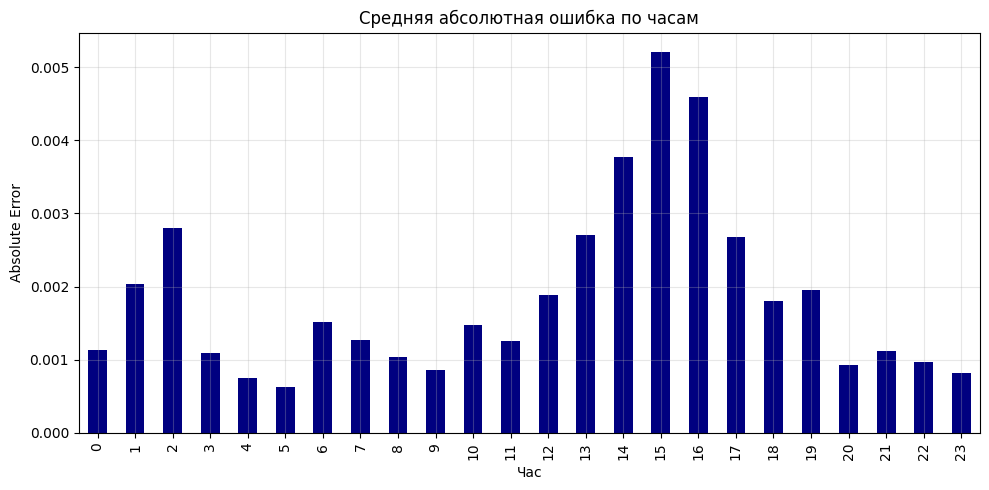

['trained_pa_model.pkl']

In [ ]:
y_full_pred = best_pa_model.predict(X)

# 2. Формируем DataFrame с результатами
result = pd.DataFrame({
    'predicted_mid_t': y_full_pred,
    'actual': y.values,
}, index=X.index)

# 3. Вычисляем ошибки и добавляем временные метки
result['abs_error'] = np.abs(result['predicted_mid_t'] - result['actual'])
result['hour'] = result.index.hour

# 4. Визуализация: ошибка по часам
result.groupby('hour')['abs_error'].mean().plot(
    kind='bar',
    title='Средняя абсолютная ошибка по часам',
    ylabel='Absolute Error',
    xlabel='Час',
    figsize=(10, 5),
    color='navy'
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Сохраняем в .parquet
pq.write_table(pa.Table.from_pandas(result), 'pa_model_results.parquet')

# 6. Сохраняем модель
joblib.dump(best_pa_model, 'trained_pa_model.pkl')y_full_pred = best_pa_model.predict(X)

# 2. Формируем DataFrame с результатами
result = pd.DataFrame({
    'predicted_mid_t': y_full_pred,
    'actual': y.values,
}, index=X.index)

# 3. Вычисляем ошибки и добавляем временные метки
result['abs_error'] = np.abs(result['predicted_mid_t'] - result['actual'])
result['hour'] = result.index.hour

# 4. Визуализация: ошибка по часам
result.groupby('hour')['abs_error'].mean().plot(
    kind='bar',
    title='Средняя абсолютная ошибка по часам',
    ylabel='Absolute Error',
    xlabel='Час',
    figsize=(10, 5),
    color='navy'
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Сохраняем в .parquet
pq.write_table(pa.Table.from_pandas(result), 'pa_model_results.parquet')

# 6. Сохраняем модель
joblib.dump(best_pa_model, 'trained_pa_model.pkl')


In [43]:
result

,predicted_mid_t,actual,abs_error,hour
local_timestamp,,,,
2024-11-01 00:00:04.600,168.635035,168.635,0.000035,0
2024-11-01 00:00:04.700,168.635018,168.635,0.000018,0
2024-11-01 00:00:04.800,168.635424,168.635,0.000424,0
2024-11-01 00:00:04.900,168.634992,168.635,0.000008,0
2024-11-01 00:00:05.000,168.635431,168.635,0.000431,0
...,...,...,...,...
2024-11-01 23:59:56.200,166.033960,166.035,0.001040,23
2024-11-01 23:59:56.300,166.033971,166.035,0.001029,23
2024-11-01 23:59:56.400,166.034028,166.035,0.000972,23


In [2]:
# Загружаем
df = pd.read_parquet(r'E:\Users\glytn\Desktop\ml\course\data\pa_model_results.parquet')
mid_price = df['predicted_mid_t'].values
timestamps = df.index


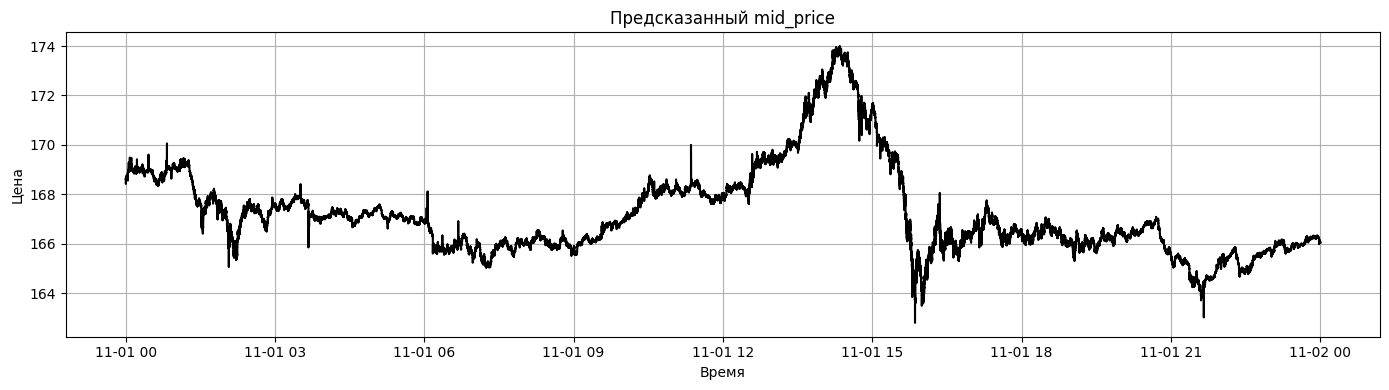

In [3]:
plt.figure(figsize=(14, 4))
plt.plot(timestamps, mid_price, color='black')
plt.title("Предсказанный mid_price")
plt.xlabel("Время")
plt.ylabel("Цена")
plt.grid(True)
plt.tight_layout()
plt.show()


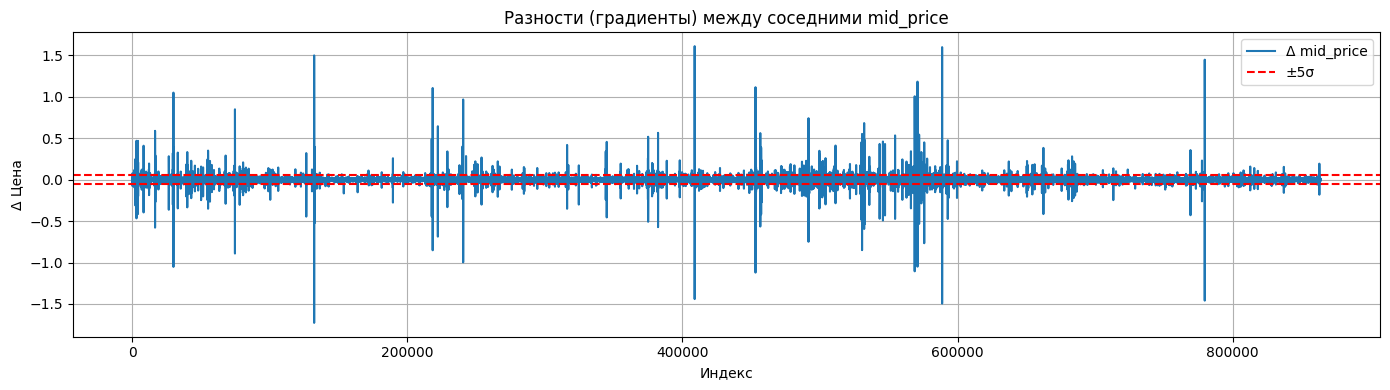

In [4]:
mid_diff = np.diff(mid_price)
threshold = 5 * np.std(mid_diff)

plt.figure(figsize=(14, 4))
plt.plot(mid_diff, label='Δ mid_price')
plt.axhline(threshold, color='red', linestyle='--', label='±5σ')
plt.axhline(-threshold, color='red', linestyle='--')
plt.title("Разности (градиенты) между соседними mid_price")
plt.xlabel("Индекс")
plt.ylabel("Δ Цена")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
